# MSN news data set
----

1. The MIND dataset will be available at https://msnews.github.io.

2. The implementation of several existing news recommendation methods and general recommendation methods can be found at Microsoft Recommenders https://github.com/microsoft/recommenders

3. step-by-step tutorial 
https://towardsdatascience.com/a-step-by-step-guide-to-the-microsoft-news-recommendation-competition-700ab00831a

4. Data Set Description
https://github.com/msnews/msnews.github.io/blob/master/assets/doc/introduction.md


# Assignment Requirement
The assignment is to build a Recommender Syste that incorporates pluriformity and diversity to the algorithms and the metrics for an interactive news platform , using this data.  

Also in this final assignment we are extra attentive to the question of whether (how) the values, algorithmic affordances, and metrics align (check the elephant in the room slide of last lecture here) and to your empirical, technical and conceptual investigations for the concept.

There is also a folder for suggested readings on the challenges of news recommender system and diversity , that I would add some useful short readings to it. 


# Data Set
two folders for the same data

- MIND-large
    - the news click behaviors of these users in this period, which are formatted into impression logs.
    - the impression logs in the last week for test, and the logs in the fifth week for training


- MIND (MIND-small)
    - by randomly sampling 50,000 users and their behavior logs from the MIND dataset
    - Only training and validation sets are contained in the MIND-small dataset.

----

- MIND-large
    - **training**
        - the click behaviors in the first four weeks to construct the news click history for user modeling.
    - **validation** 
        - Among the training data, we used the samples in the last day of the fifth week as validation set. 
    - **testing set**    
    
    
- MIND (MIND-small)  
    - **training**
    - **validation** 



In [60]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
# from torch.utils.data import *

import time
import random
import re

import matplotlib.pyplot as plt 
%matplotlib inline

import pdb
from tqdm.auto import tqdm

In [61]:
train_news = pd.read_csv("data/Small_data_set/MINDsmall_train/news.tsv", sep="\t", header=None)
train_behaviors = pd.read_csv("data/Small_data_set/MINDsmall_train/behaviors.tsv", sep="\t", header=None)

dev_news = pd.read_csv("data/Small_data_set/MINDsmall_dev/news.tsv", sep="\t", header=None)
dev_behaviors = pd.read_csv("data/Small_data_set/MINDsmall_dev/behaviors.tsv", sep="\t", header=None)

In [62]:

columns = ["News_ID","Category","Subcategory","News_Title","News_Abstrct",
           "News_Url","Entities_in_News_Title","Entities_in_News_Abstract"]
train_news.columns = columns
train_news.head(3)

,News_ID,Category,Subcategory,News_Title,News_Abstrct,News_Url,Entities_in_News_Title,Entities_in_News_Abstract
0,N55528,lifestyle,lifestyleroyals,"The Brands Queen Elizabeth, Prince Charles, an...","Shop the notebooks, jackets, and more that the...",https://assets.msn.com/labs/mind/AAGH0ET.html,"[{""Label"": ""Prince Philip, Duke of Edinburgh"",...",[]
1,N19639,health,weightloss,50 Worst Habits For Belly Fat,These seemingly harmless habits are holding yo...,https://assets.msn.com/labs/mind/AAB19MK.html,"[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik...","[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik..."
2,N61837,news,newsworld,The Cost of Trump's Aid Freeze in the Trenches...,Lt. Ivan Molchanets peeked over a parapet of s...,https://assets.msn.com/labs/mind/AAJgNsz.html,[],"[{""Label"": ""Ukraine"", ""Type"": ""G"", ""WikidataId..."


In [63]:
train_news.describe()

,News_ID,Category,Subcategory,News_Title,News_Abstrct,News_Url,Entities_in_News_Title,Entities_in_News_Abstract
count,51282,51282,51282,51282,48616,51282,51279,51278
unique,51282,17,264,50434,47309,51281,34472,36277
top,N53673,news,newsus,Photos of the Day,What's the weather today? What's the weather f...,[],[],[]
freq,1,15774,6564,15,124,2,13842,13825


In [64]:
columns = ["Impression ID","User ID","Impression Time","User Click History","Impression New"]
train_behaviors.columns = columns
train_behaviors.head(3)

,Impression ID,User ID,Impression Time,User Click History,Impression New
0,1,U13740,11/11/2019 9:05:58 AM,N55189 N42782 N34694 N45794 N18445 N63302 N104...,N55689-1 N35729-0
1,2,U91836,11/12/2019 6:11:30 PM,N31739 N6072 N63045 N23979 N35656 N43353 N8129...,N20678-0 N39317-0 N58114-0 N20495-0 N42977-0 N...
2,3,U73700,11/14/2019 7:01:48 AM,N10732 N25792 N7563 N21087 N41087 N5445 N60384...,N50014-0 N23877-0 N35389-0 N49712-0 N16844-0 N...


In [65]:
train_behaviors.describe()

,Impression ID
count,156965.000000
mean,78483.000000
std,45312.036839
min,1.000000
25%,39242.000000
50%,78483.000000
75%,117724.000000
max,156965.000000


# Plot the category distribution

In [66]:
train_news.head(1)

,News_ID,Category,Subcategory,News_Title,News_Abstrct,News_Url,Entities_in_News_Title,Entities_in_News_Abstract
0,N55528,lifestyle,lifestyleroyals,"The Brands Queen Elizabeth, Prince Charles, an...","Shop the notebooks, jackets, and more that the...",https://assets.msn.com/labs/mind/AAGH0ET.html,"[{""Label"": ""Prince Philip, Duke of Edinburgh"",...",[]


In [67]:
train_news.shape

(51282, 8)

In [68]:
# ['lifestyle','health','news','sports','weather','entertainment','autos','travel',
# 'foodanddrink','tv','finance','movies','video','music','kids','middleeast','northamerica']
category_lst = list(train_news['Category'].unique())

In [69]:
cal1 = train_news[['News_ID','Category']].groupby(['Category']).count().reset_index()
cal1.columns = ['Category','count']

cal2 = train_news[['News_ID','Category','Subcategory']].groupby(['Category','Subcategory']).count().reset_index()
cal2.columns = ['Category','Subcategory','count']


No handles with labels found to put in legend.


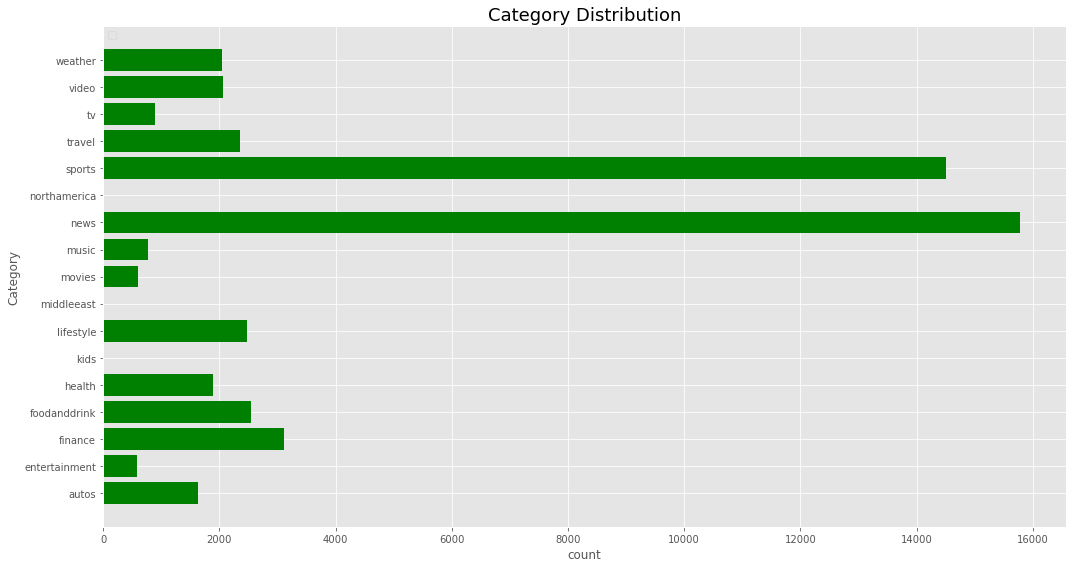

In [88]:
# Plot the summarize for category distribution 
plt.style.use('ggplot')

fig, ax = plt.subplots(1,1,figsize=(15,8))

columns = list(cal1['Category'])
lst = list(cal1['count'])

x_pos = [i for i, _ in enumerate(columns)]
ax.barh(x_pos, lst, color='green')

ax.set_yticks(x_pos) # values
ax.set_yticklabels(columns) # labels

ax.set_title('Category Distribution',fontsize=18)
ax.set_ylabel('Category')
ax.set_xlabel('count')
ax.legend(loc='upper left')

plt.tight_layout()

No handles with labels found to put in legend.
No handles with labels found to put in legend.


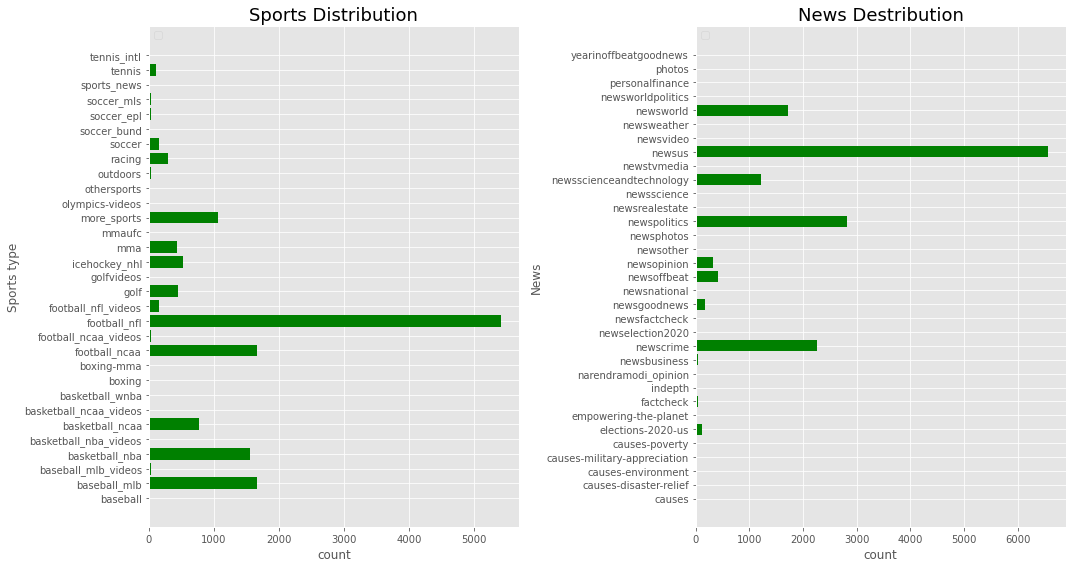

In [89]:
# Plot the summarize for Subcategory distribution 
plt.style.use('ggplot')

fig, ax = plt.subplots(1,2,figsize=(15,8))

#plot for sports
sports = cal2[ cal2['Category'].isin(['sports'])] 
columns = list(sports['Subcategory'])
lst = list(sports['count'])

x_pos = [i for i, _ in enumerate(columns)]
ax[0].barh(x_pos, lst, color='green')

ax[0].set_yticks(x_pos) # values
ax[0].set_yticklabels(columns) # labels

ax[0].set_title('Sports Distribution',fontsize=18)
ax[0].set_ylabel('Sports type')
ax[0].set_xlabel('count')
ax[0].legend(loc='upper left')


# plot for news
news = cal2[ cal2['Category'].isin(['news'])] 
columns = list(news['Subcategory'])
lst = list(news['count'])

x_pos = [i for i, _ in enumerate(columns)]
ax[1].barh(x_pos, lst, color='green')

ax[1].set_yticks(x_pos) # values
ax[1].set_yticklabels(columns) # labels

ax[1].set_title('News Destribution',fontsize=18)
ax[1].set_ylabel('News')
ax[1].set_xlabel('count')
ax[1].legend(loc='upper left')

plt.tight_layout()